This is an example Notebook for a full analysis of the Decision Tree for a Subset of our Dataset:

    -Data perperation
    -Grid_Search for model parameters
    -Model Analysis

In [116]:
import  joblib

import  numpy               as  np
import  pandas              as  pd
import  seaborn             as  sns
import  matplotlib          as  mpl
import  matplotlib.pyplot   as  plt

from    sklearn.svm             import SVC
from    sklearn.tree            import DecisionTreeClassifier, plot_tree
from    sklearn.metrics         import accuracy_score, classification_report, confusion_matrix
from    sklearn.pipeline        import make_pipeline
from    sklearn.ensemble        import RandomForestClassifier
from    sklearn.linear_model    import LogisticRegression
from    sklearn.model_selection import GridSearchCV, train_test_split

# Set high-resolution matplotlib plots
mpl.rcParams['figure.dpi'] = 300

In [117]:
# Load dataset file
dataset = pd.read_csv(r"./Dataset/dataset.csv")

### Data Preparation

In [118]:
def clean_data(x):                                                                            #we define a "cleaning" function which removes any spaces in front or after the string
    if isinstance(x, str):                                                                    #Check if (object,type)
        return x.strip().replace("  ", " ").replace(" _", "_").replace("_ ", "_")             #eemove spaces from both ends of the string
    else:
        return x  


# apply the function to each column
for col in dataset.columns:
    dataset[col] = dataset[col].map(clean_data)

#we now will make the checklist of all symptoms
#List of symptom columns
symptom_cols = [
    'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5',
    'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10',
    'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15',
    'Symptom_16', 'Symptom_17'
]
#create the empty list to store all symptoms
all_symptoms = []

for col in symptom_cols:                           # go through each Symptom_1 to Symptom_17 column
    for symptom in dataset[col]:                   # go through every value in that column
        if pd.notna(symptom):                      # check if the cell is not nan
            all_symptoms.append(symptom)           # add it to the list

unique_symptoms = sorted(list(set(all_symptoms)))  #to remove the duplicates with set, we make them again a list (makes it usable for indexing and loops) and we soort them alphabetically in order to read them easier


#create a list of all diseases
disease_list = dataset['Disease'].unique()      #we use the unique function to get all diseases

#print how many symptoms we found
print("Number of unique symptoms:", len(unique_symptoms))
print("Symptoms:", unique_symptoms)

print("Number of unique diseases:", len(disease_list))
print("Symptoms:", disease_list)

binary = pd.DataFrame()                  #Create a new, empty table (DataFrame) named binary to hold the simplified data
binary['Disease'] = dataset['Disease']  #Copy the disease column from the original dataset (dataset) into the binary table

#for each syptom we check ecah row
for symptom in unique_symptoms:
    binary[symptom] = dataset[symptom_cols].eq(symptom).any(axis=1).astype(int)
#so what we basically did : For each symptom in your list, check every patient.Mark 1 if the patient has this symptom anywhere, or 0 if not

Number of unique symptoms: 131
Symptoms: ['abdominal_pain', 'abnormal_menstruation', 'acidity', 'acute_liver_failure', 'altered_sensorium', 'anxiety', 'back_pain', 'belly_pain', 'blackheads', 'bladder_discomfort', 'blister', 'blood_in_sputum', 'bloody_stool', 'blurred_and_distorted_vision', 'breathlessness', 'brittle_nails', 'bruising', 'burning_micturition', 'chest_pain', 'chills', 'cold_hands_and_feets', 'coma', 'congestion', 'constipation', 'continuous_feel_of_urine', 'continuous_sneezing', 'cough', 'cramps', 'dark_urine', 'dehydration', 'depression', 'diarrhoea', 'dischromic_patches', 'distention_of_abdomen', 'dizziness', 'drying_and_tingling_lips', 'enlarged_thyroid', 'excessive_hunger', 'extra_marital_contacts', 'family_history', 'fast_heart_rate', 'fatigue', 'fluid_overload', 'foul_smell_of urine', 'headache', 'high_fever', 'hip_joint_pain', 'history_of_alcohol_consumption', 'increased_appetite', 'indigestion', 'inflammatory_nails', 'internal_itching', 'irregular_sugar_level', '

/var/folders/2z/gg72mtn93pgbw7k8w_rzyr0h0000gn/T/ipykernel_72738/2134992988.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  binary[symptom] = dataset[symptom_cols].eq(symptom).any(axis=1).astype(int)
/var/folders/2z/gg72mtn93pgbw7k8w_rzyr0h0000gn/T/ipykernel_72738/2134992988.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  binary[symptom] = dataset[symptom_cols].eq(symptom).any(axis=1).astype(int)
/var/folders/2z/gg72mtn93pgbw7k8w_rzyr0h0000gn/T/ipykernel_72738/2134992988.py:46: PerformanceWarning: DataFrame is highly f

We are only using a small subset of the whole Dataset

In [119]:
#subset consits of only these diseases 'Fungal infection' 'Allergy' 'GERD' 'Chronic cholestasis' 'Drug Reaction'
subset  = binary[binary['Disease'].isin(['Fungal infection', 'Allergy', 'GERD', 'Chronic cholestasis', 'Drug Reaction'])]

#save_subset
subset.to_csv(r"./Dataset/subset.csv", index=False)  # Save the subset to a new CSV file

#Prepare the data
X_binary = subset.drop(columns=['Disease'])  # All columns except Disease
y_binary = subset['Disease']  # Target column

#Split the data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.7, random_state=42)

In [120]:
param_grid = {'ccp_alpha': [0.1, .01, .001, .0001],
              'max_depth' : range(4,10),
              'criterion' :['gini', 'entropy','log_loss'],
             }

model = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)

final_model = grid_search.best_estimator_

#Save the model
joblib.dump(final_model, './Models_Subset/decision_tree_model.pkl')

print(final_model)

# Train
final_model.fit(X_train_bin, y_train_bin)

# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 72 candidates, totalling 360 fits
DecisionTreeClassifier(ccp_alpha=0.01, criterion='entropy', max_depth=5,
                       random_state=42)
                     precision    recall  f1-score   support

            Allergy       1.00      1.00      1.00        83
Chronic cholestasis       1.00      0.93      0.96        82
      Drug Reaction       1.00      1.00      1.00        86
   Fungal infection       1.00      1.00      1.00        83
               GERD       0.93      1.00      0.97        86

           accuracy                           0.99       420
          macro avg       0.99      0.99      0.99       420
       weighted avg       0.99      0.99      0.99       420



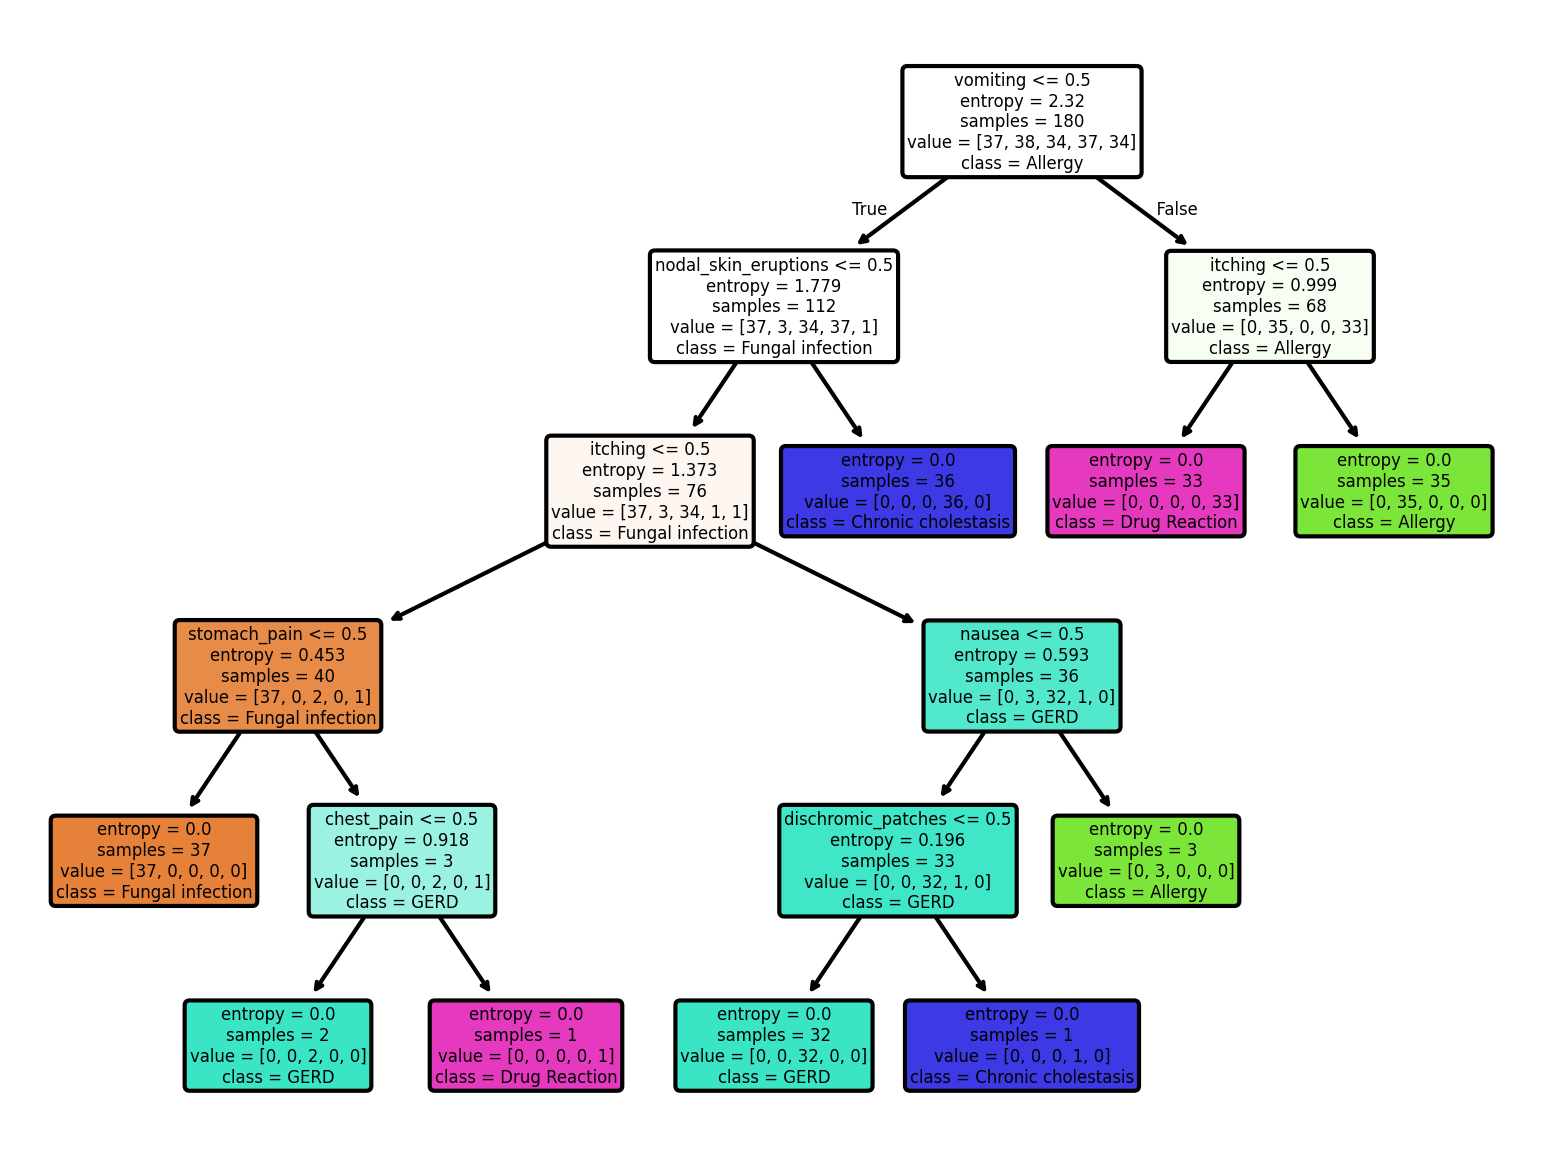

In [121]:
# Plot decision tree
plot_tree(final_model, filled=True, feature_names=X_binary.columns, class_names=y_binary.unique(), rounded=True)
# Save plot
plt.savefig("./Plots/Classifier_Subset/tree_graph.pdf")
# Show plot
plt.show()

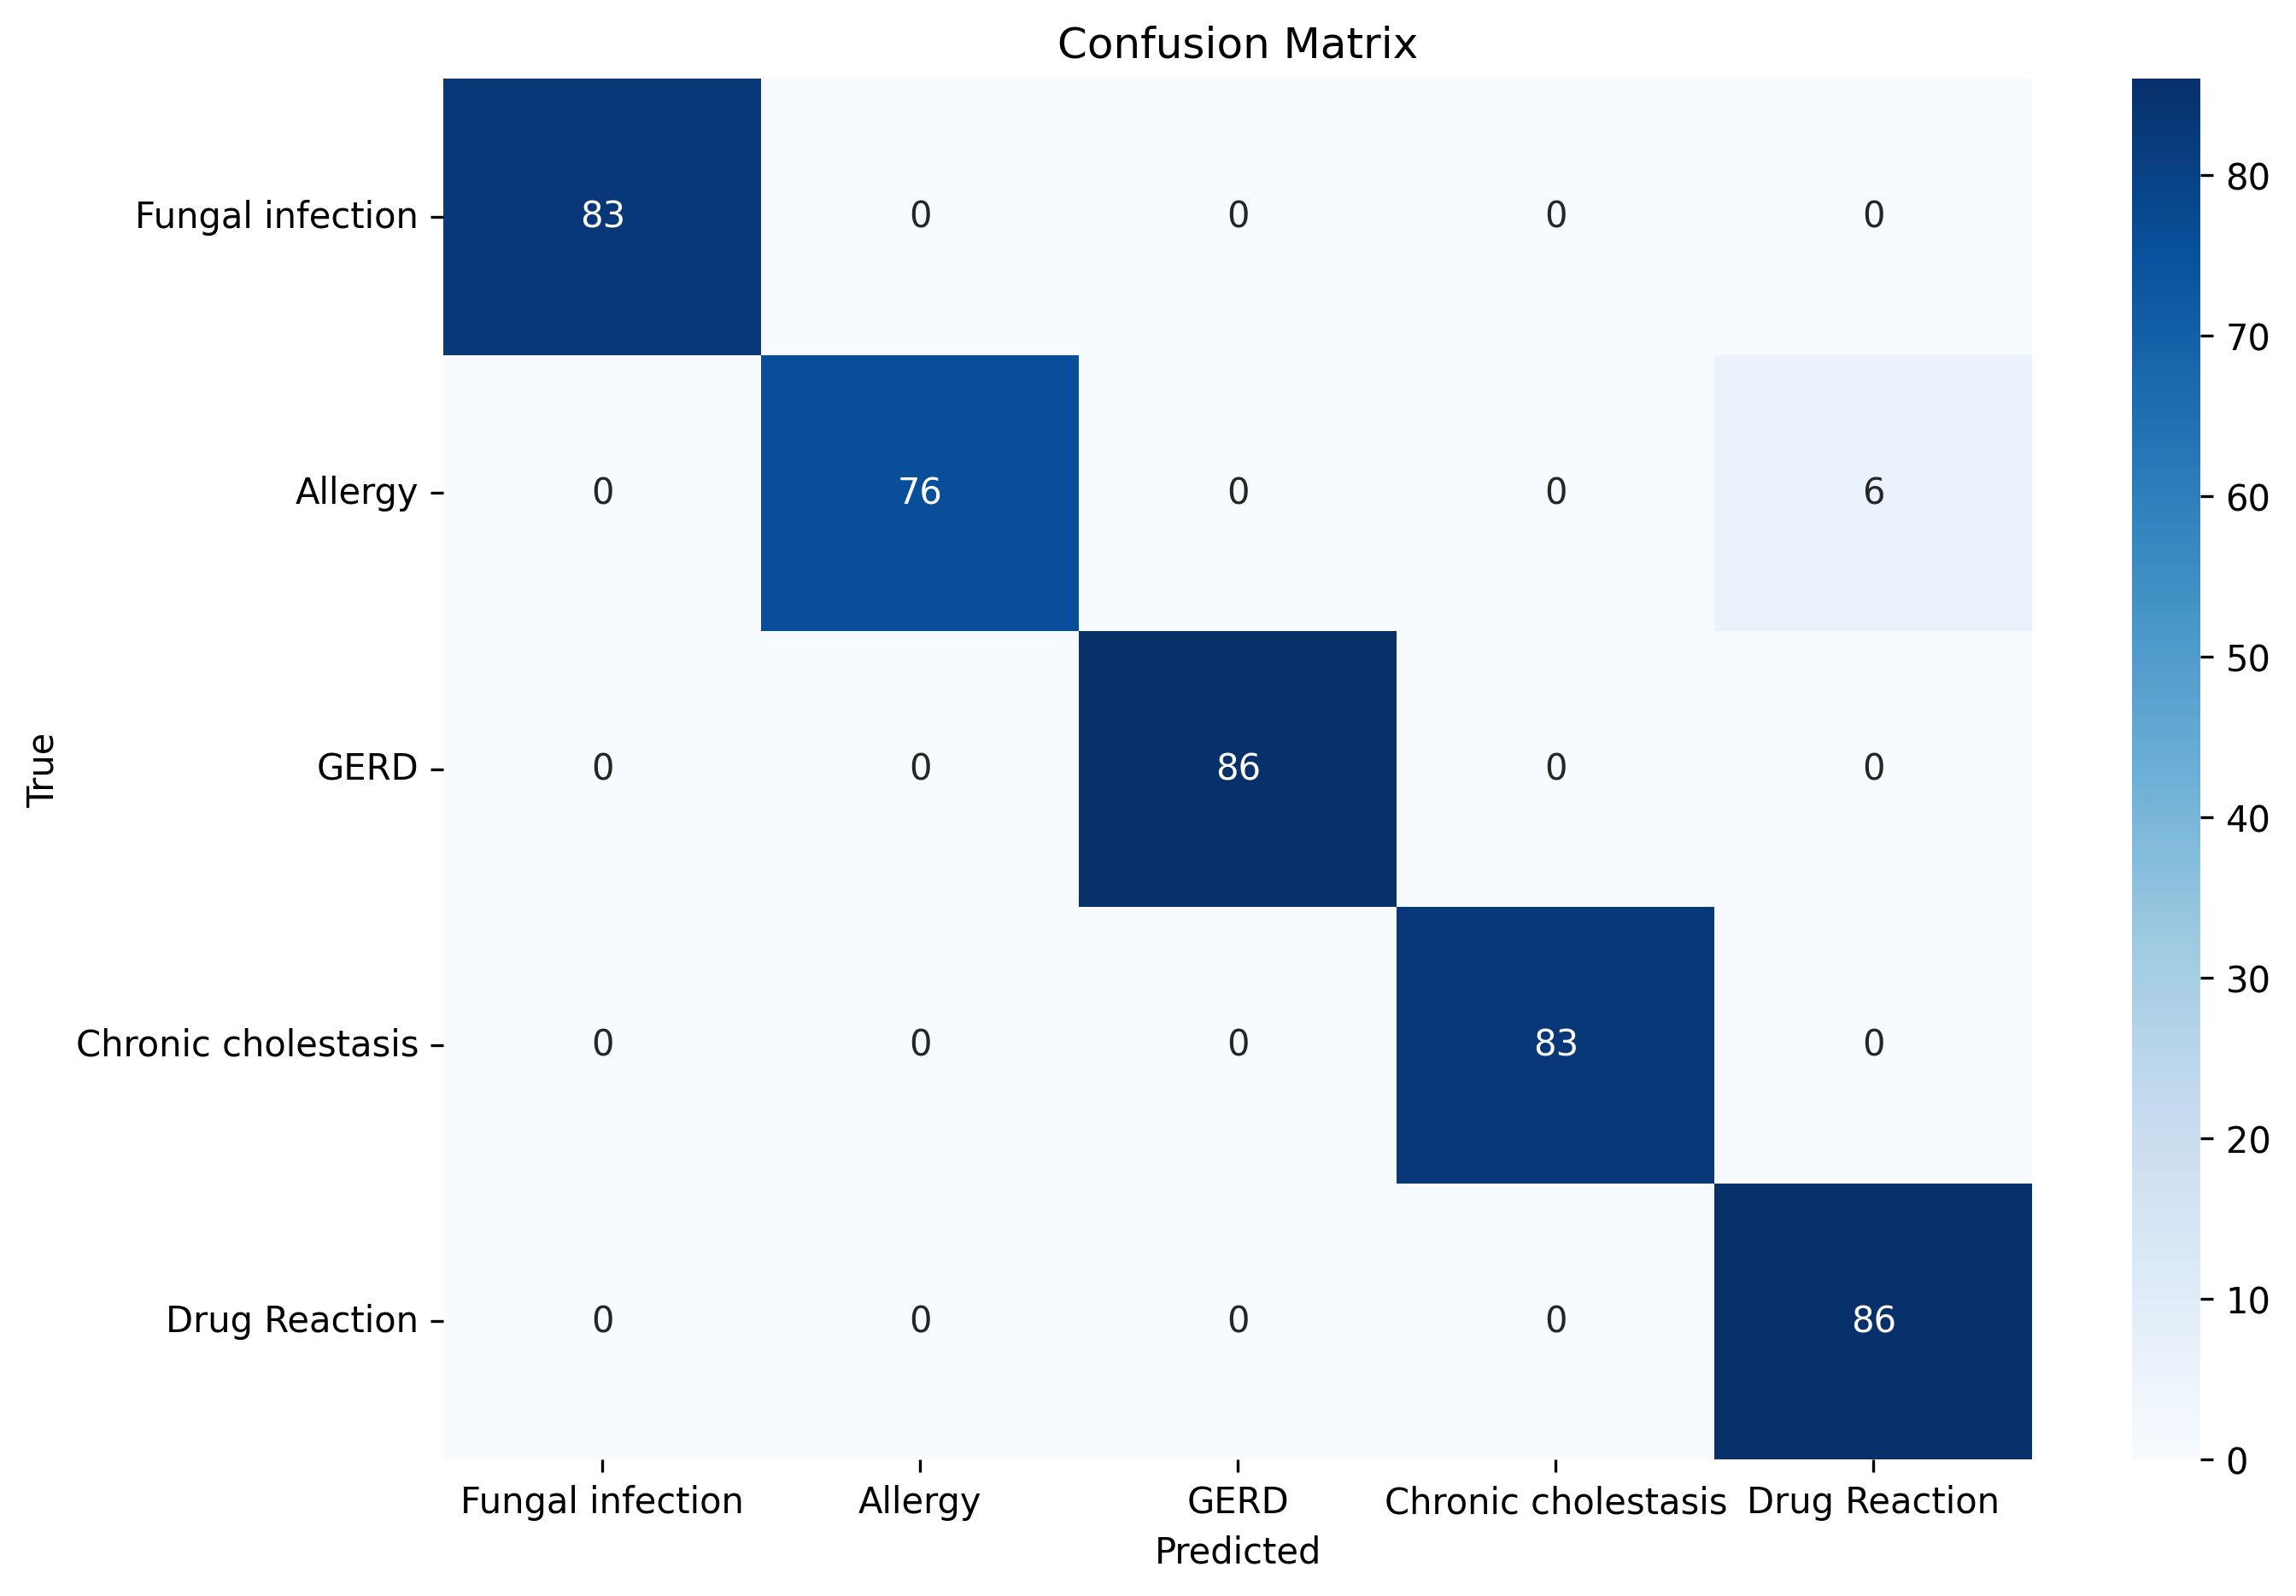

In [122]:
# Create confusion matrix
cm = confusion_matrix(y_test_bin, predictions)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_binary.unique(), yticklabels=y_binary.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [123]:
param_grid = {'n_estimators': [1,2,5,10,20],
              'max_depth' : range(2,8),
              'criterion' :['gini', 'entropy','log_loss'],
             }

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)

final_model = grid_search.best_estimator_

# Save model
joblib.dump(final_model, './models_subset/random_forest_model.pkl')
print(final_model)

# Train
final_model.fit(X_train_bin, y_train_bin)

# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 90 candidates, totalling 450 fits
RandomForestClassifier(max_depth=2, n_estimators=10, random_state=42)
                     precision    recall  f1-score   support

            Allergy       1.00      1.00      1.00        83
Chronic cholestasis       1.00      1.00      1.00        82
      Drug Reaction       1.00      1.00      1.00        86
   Fungal infection       1.00      1.00      1.00        83
               GERD       1.00      1.00      1.00        86

           accuracy                           1.00       420
          macro avg       1.00      1.00      1.00       420
       weighted avg       1.00      1.00      1.00       420



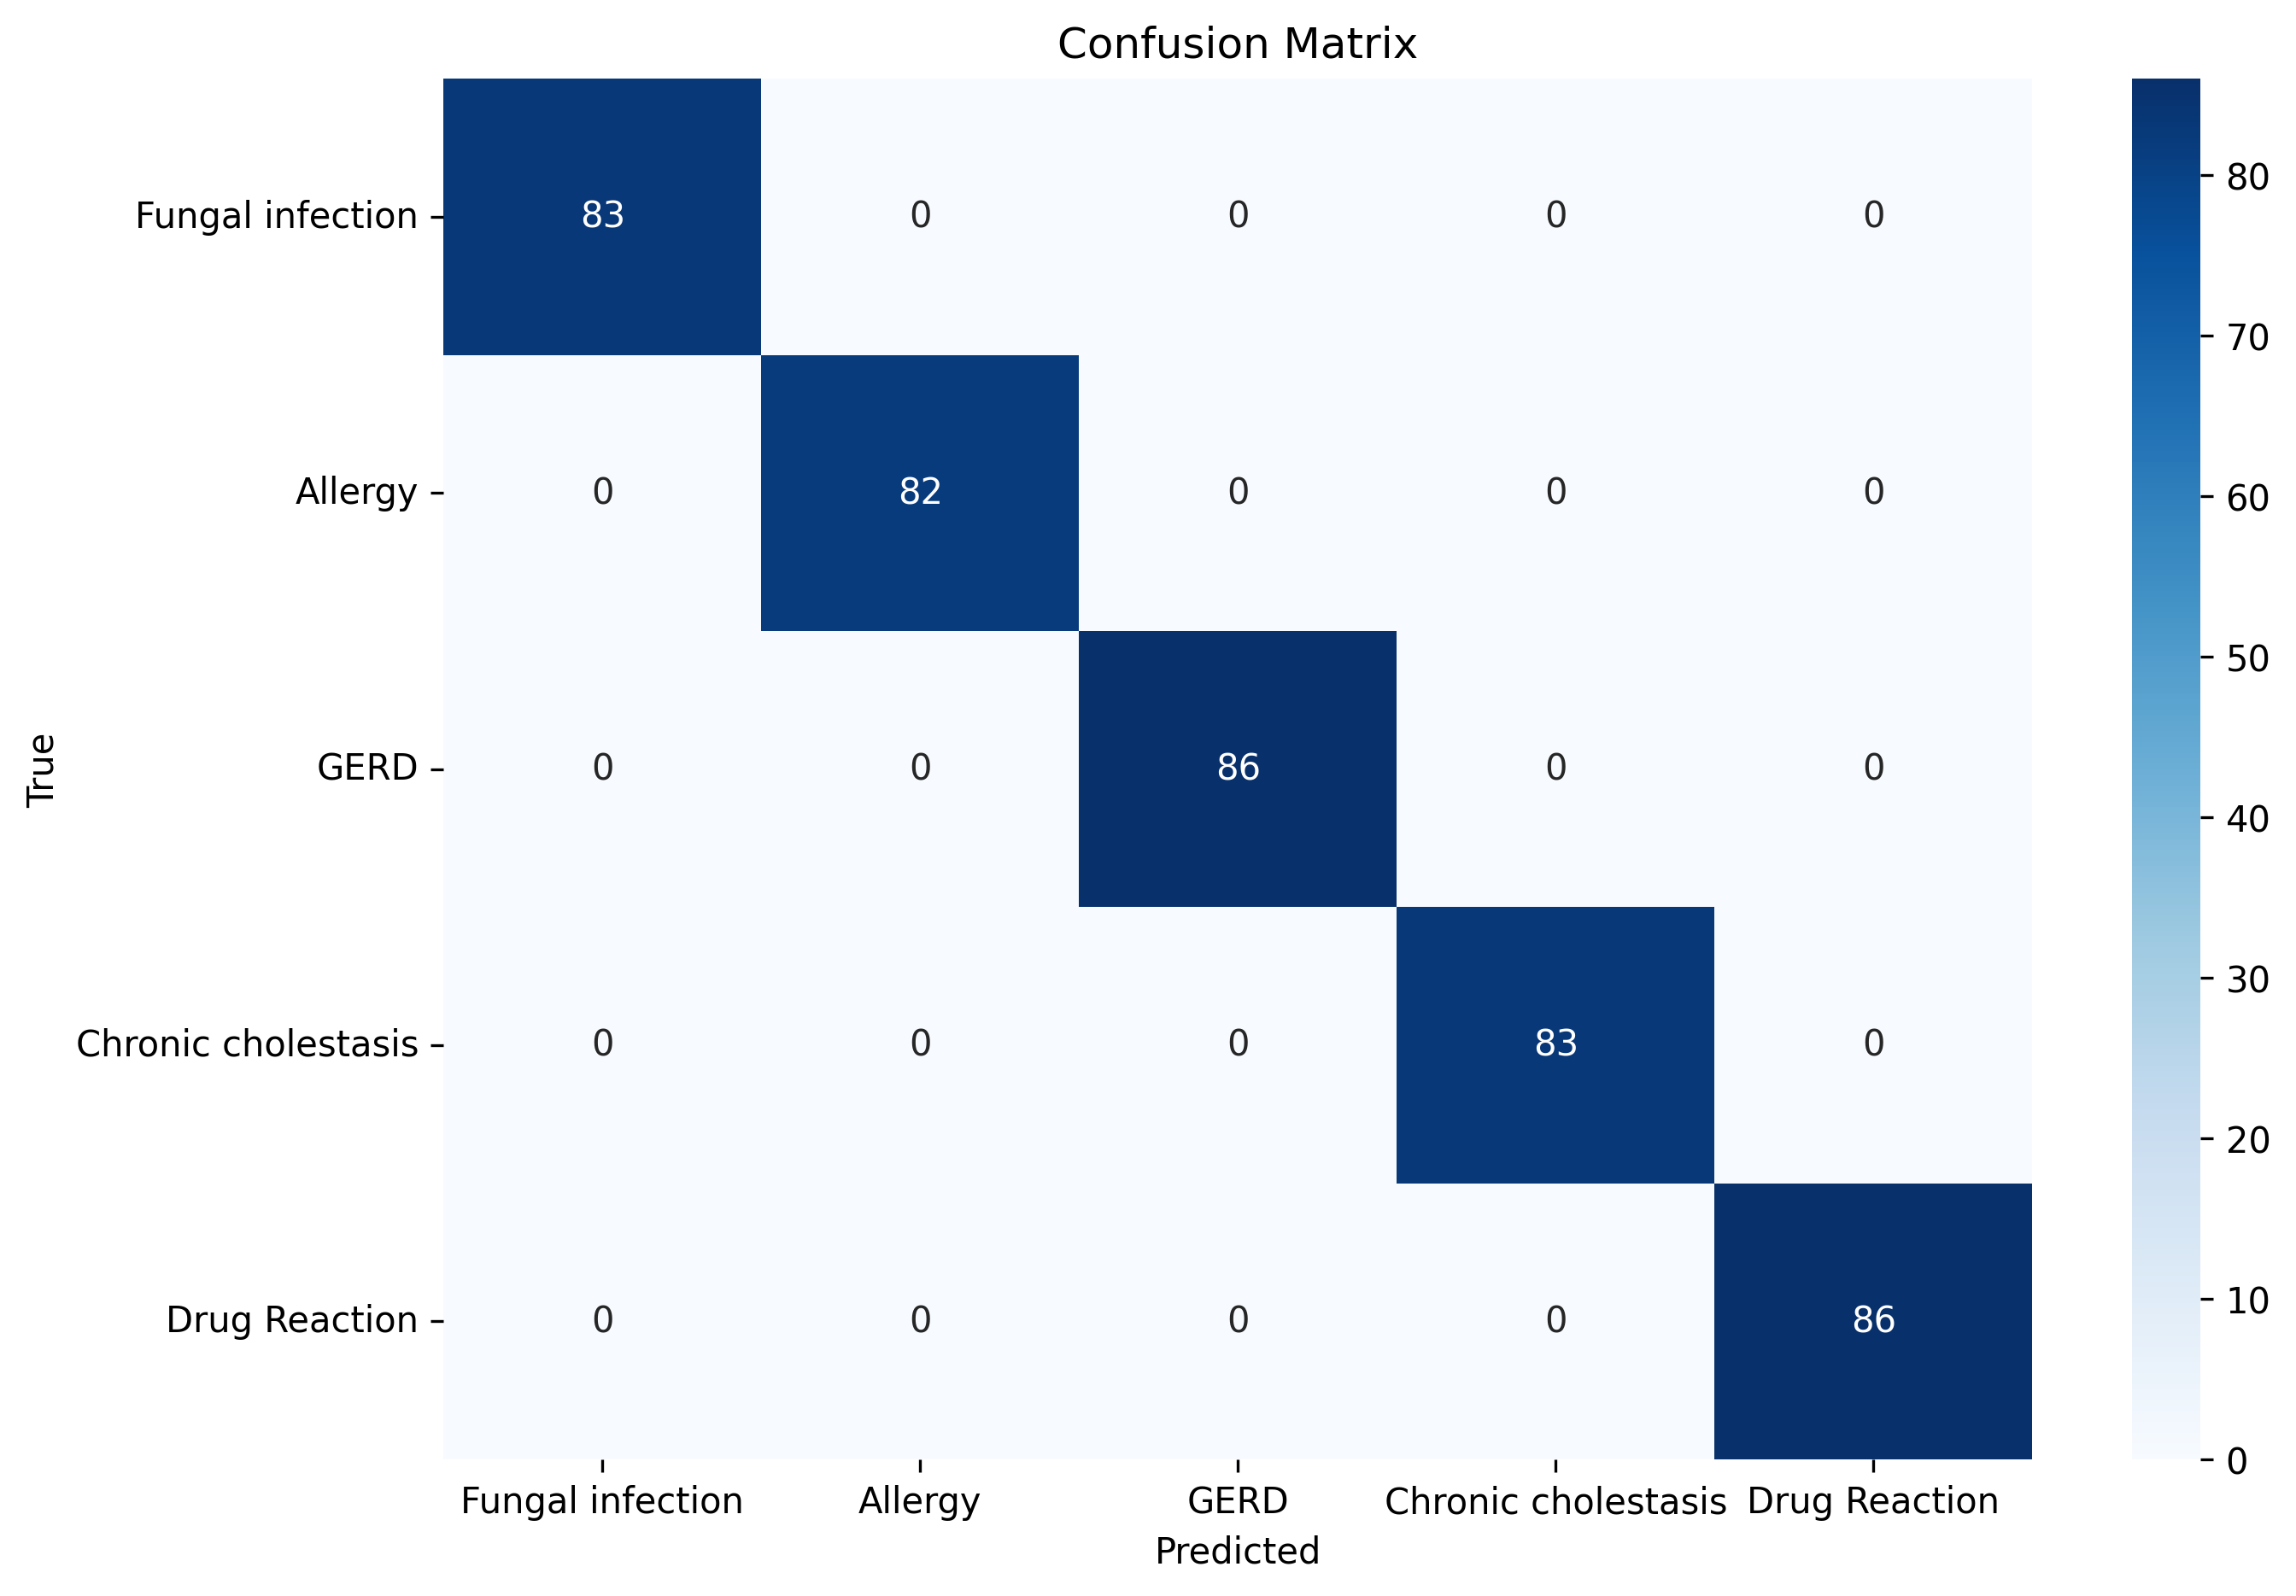

In [124]:
# Create confusion matrix
cm = confusion_matrix(y_test_bin, predictions)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_binary.unique(), yticklabels=y_binary.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Logic Regression

In [125]:
# Create a pipeline with StandardScaler and LogisticRegression

param_grid = {'tol' : [0.1, .2, .5, 1],
              'max_iter' : [1,2,5,10,20],
              'solver' :['lbfgs', 'newton-cg', 'sag', 'saga'],
             }

# Create a logistic regression model
model = LogisticRegression(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)

final_model = grid_search.best_estimator_
joblib.dump(final_model, './Models_Subset/logistic_regression_model.pkl')
print(final_model)


# Train
final_model.fit(X_train_bin, y_train_bin)


# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))

Fitting 5 folds for each of 80 candidates, totalling 400 fits


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

LogisticRegression(max_iter=1, random_state=42, tol=0.1)
                     precision    recall  f1-score   support

            Allergy       1.00      1.00      1.00        83
Chronic cholestasis       1.00      1.00      1.00        82
      Drug Reaction       1.00      1.00      1.00        86
   Fungal infection       1.00      1.00      1.00        83
               GERD       1.00      1.00      1.00        86

           accuracy                           1.00       420
          macro avg       1.00      1.00      1.00       420
       weighted avg       1.00      1.00      1.00       420



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

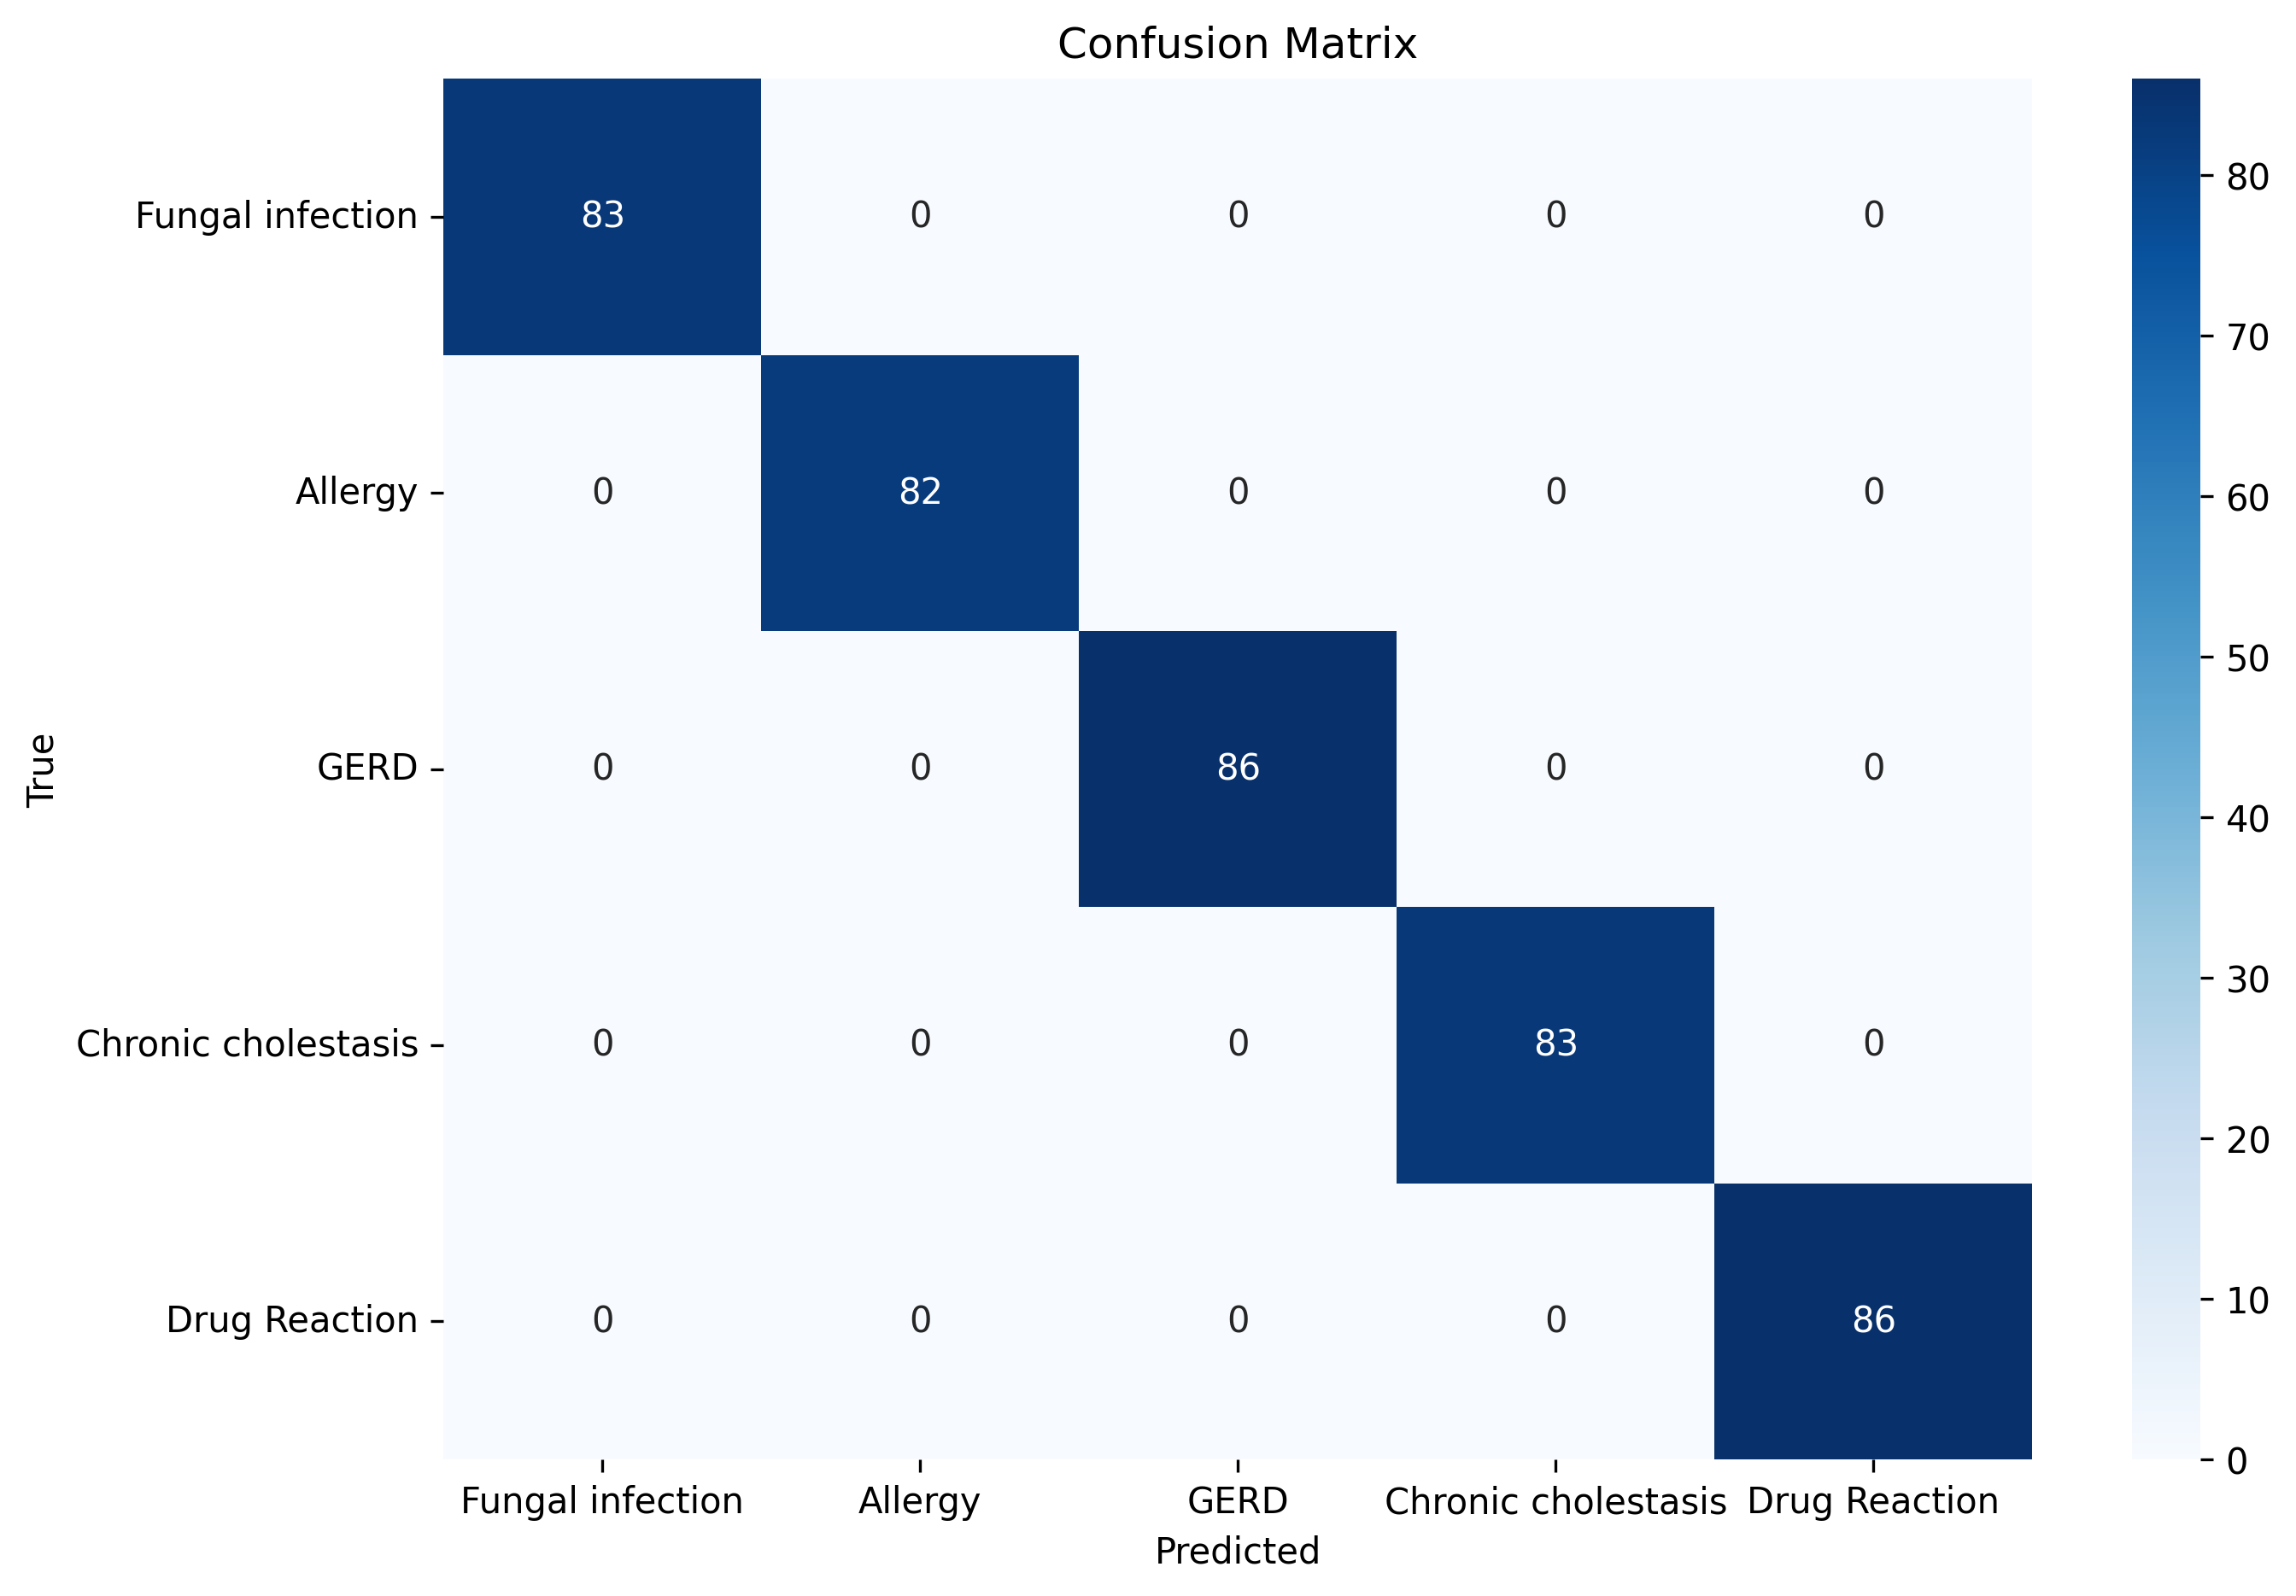

In [126]:
cm = confusion_matrix(y_test_bin, predictions)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_binary.unique(), yticklabels=y_binary.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Support Vector Machine

In [127]:
#SVM

param_grid = {'C' : [0.1, .2, .5, 1],
              'kernel' : ['linear', 'poly', 'rbf', 'sigmoid'],
              'degree' : [1,2,3,4],
             }

# Create a logistic regression model
model = SVC(random_state=42)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=True)
grid_search.fit(X_train_bin, y_train_bin)
final_model = grid_search.best_estimator_
joblib.dump(final_model, './Models_Subset/support_vector_model.pkl')
print(final_model)
# Train
final_model.fit(X_train_bin, y_train_bin)
# Prediction
predictions = final_model.predict(X_test_bin)

# Evaluation
print(classification_report(y_test_bin, predictions))


Fitting 5 folds for each of 64 candidates, totalling 320 fits
SVC(C=0.1, degree=1, kernel='linear', random_state=42)
                     precision    recall  f1-score   support

            Allergy       1.00      1.00      1.00        83
Chronic cholestasis       1.00      1.00      1.00        82
      Drug Reaction       1.00      1.00      1.00        86
   Fungal infection       1.00      1.00      1.00        83
               GERD       1.00      1.00      1.00        86

           accuracy                           1.00       420
          macro avg       1.00      1.00      1.00       420
       weighted avg       1.00      1.00      1.00       420



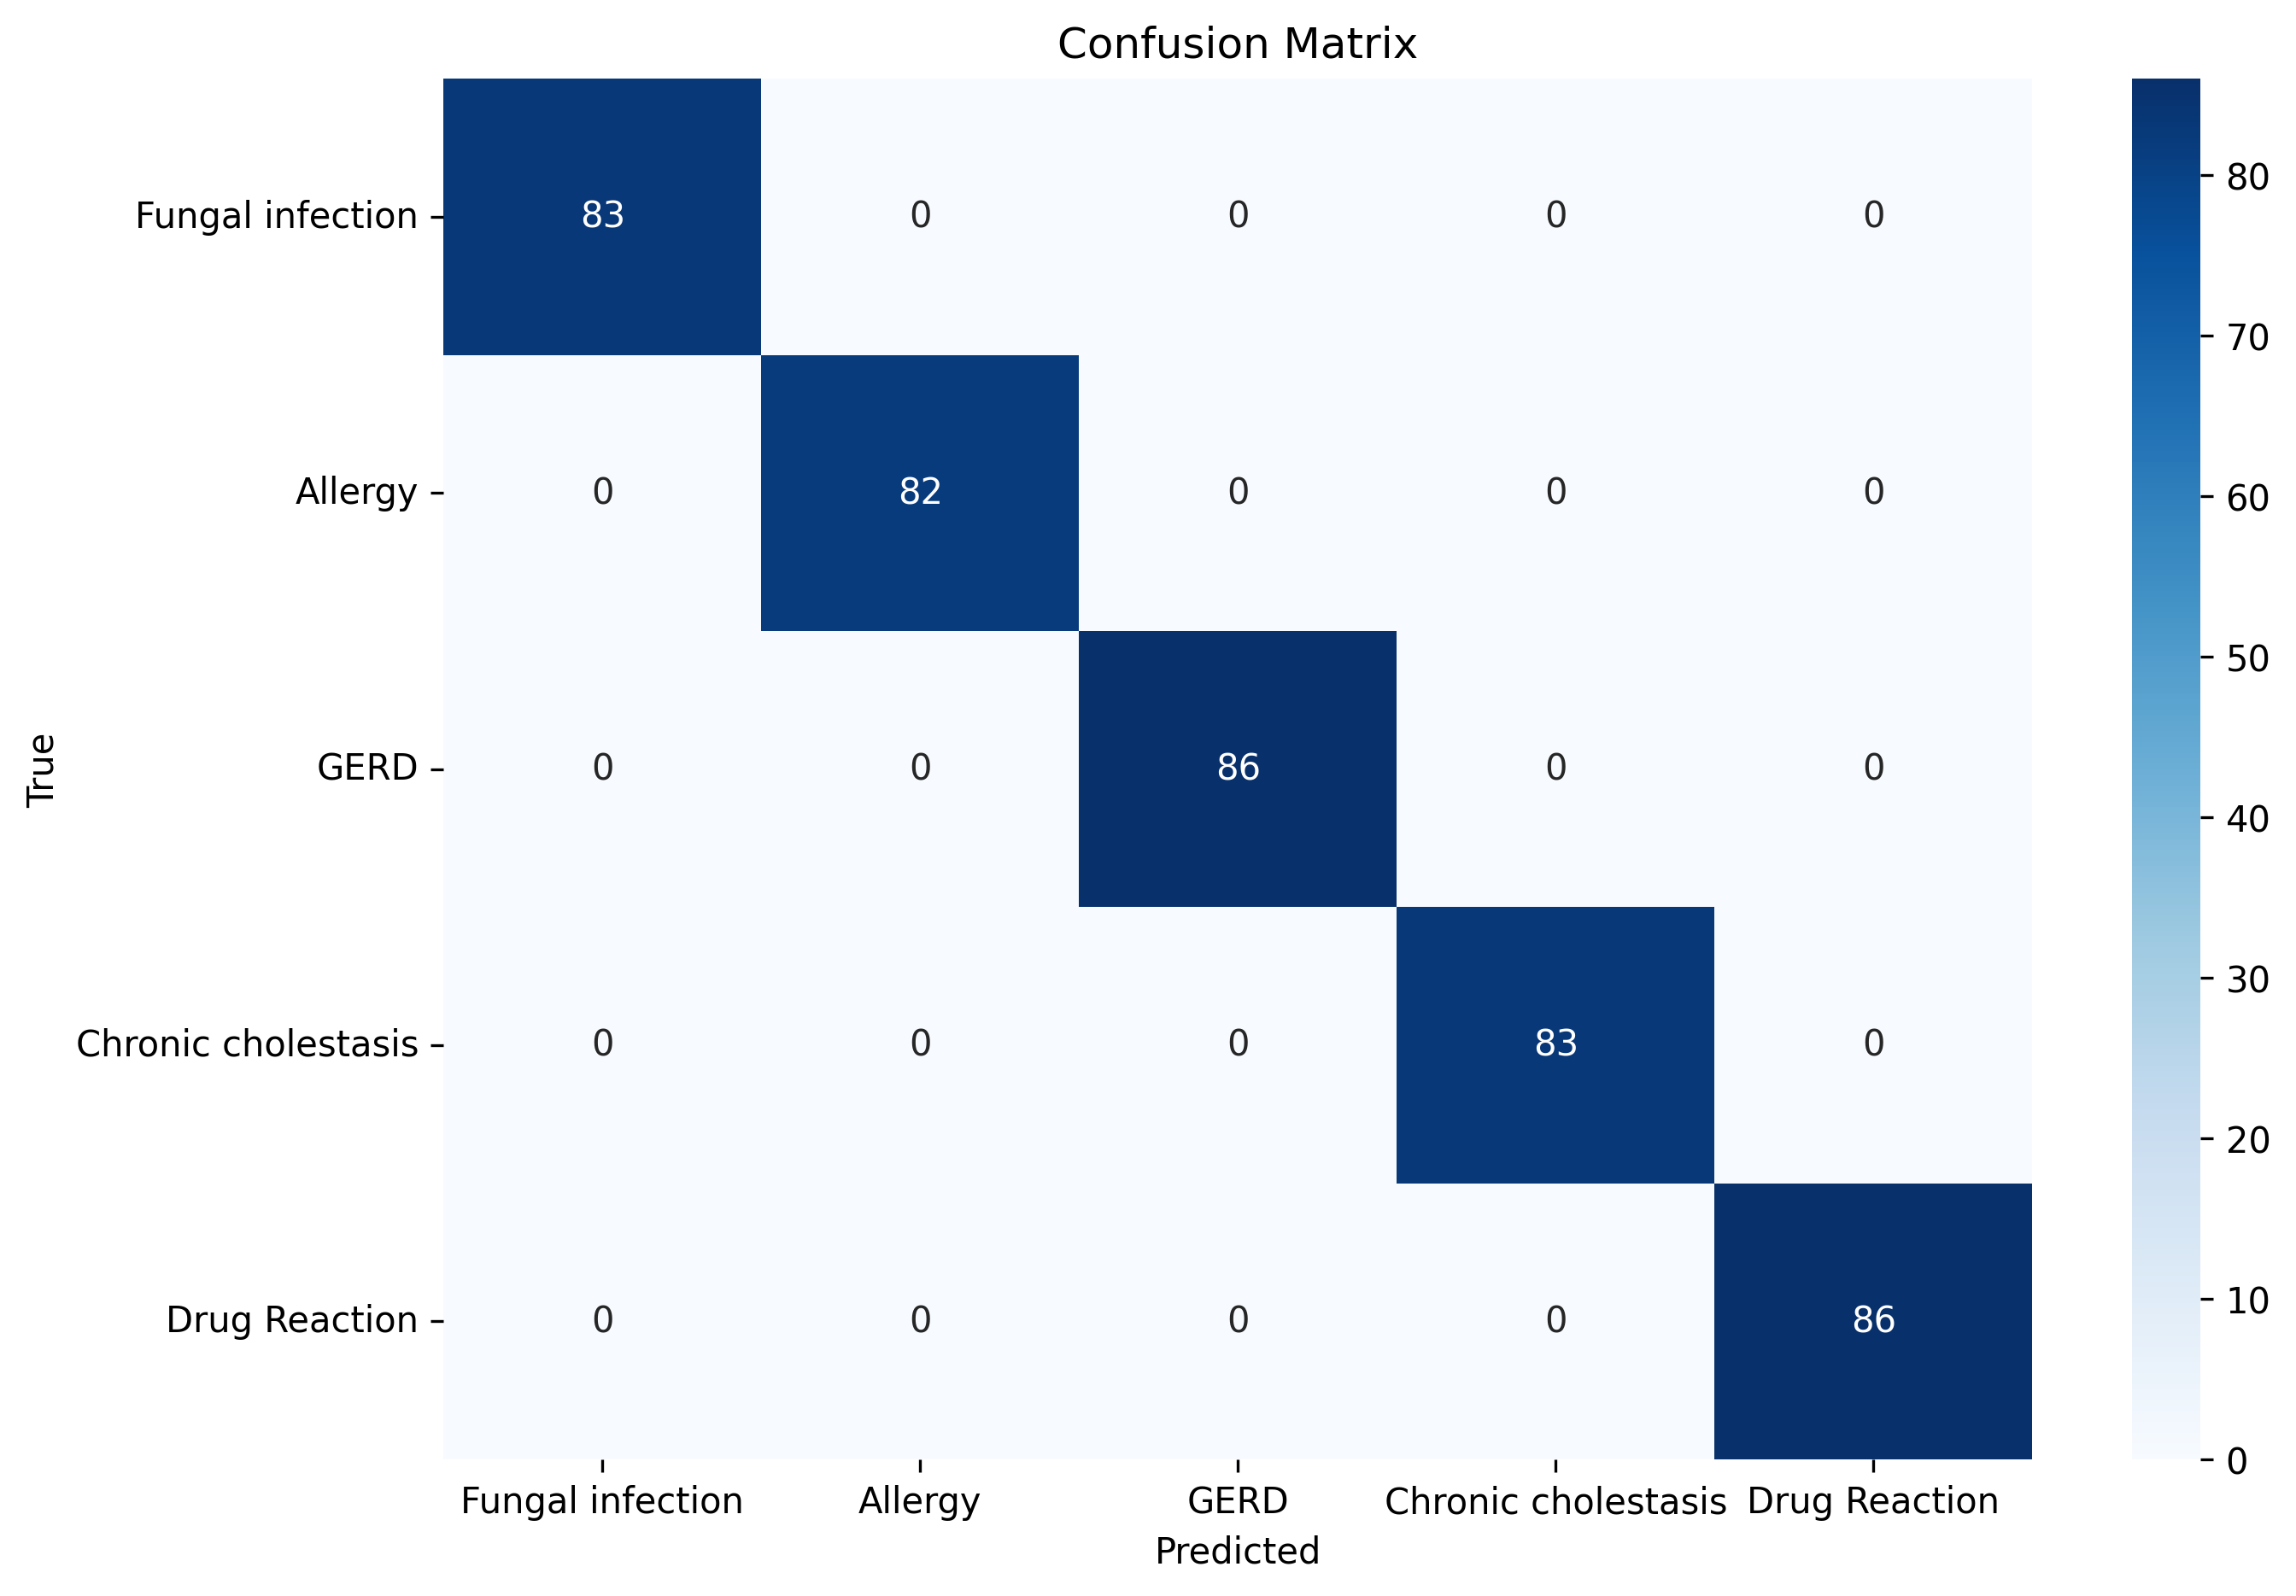

In [128]:
cm = confusion_matrix(y_test_bin, predictions)
# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=y_binary.unique(), yticklabels=y_binary.unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### **Model Accuracy on "Corrupted" Dataset (Unused)**

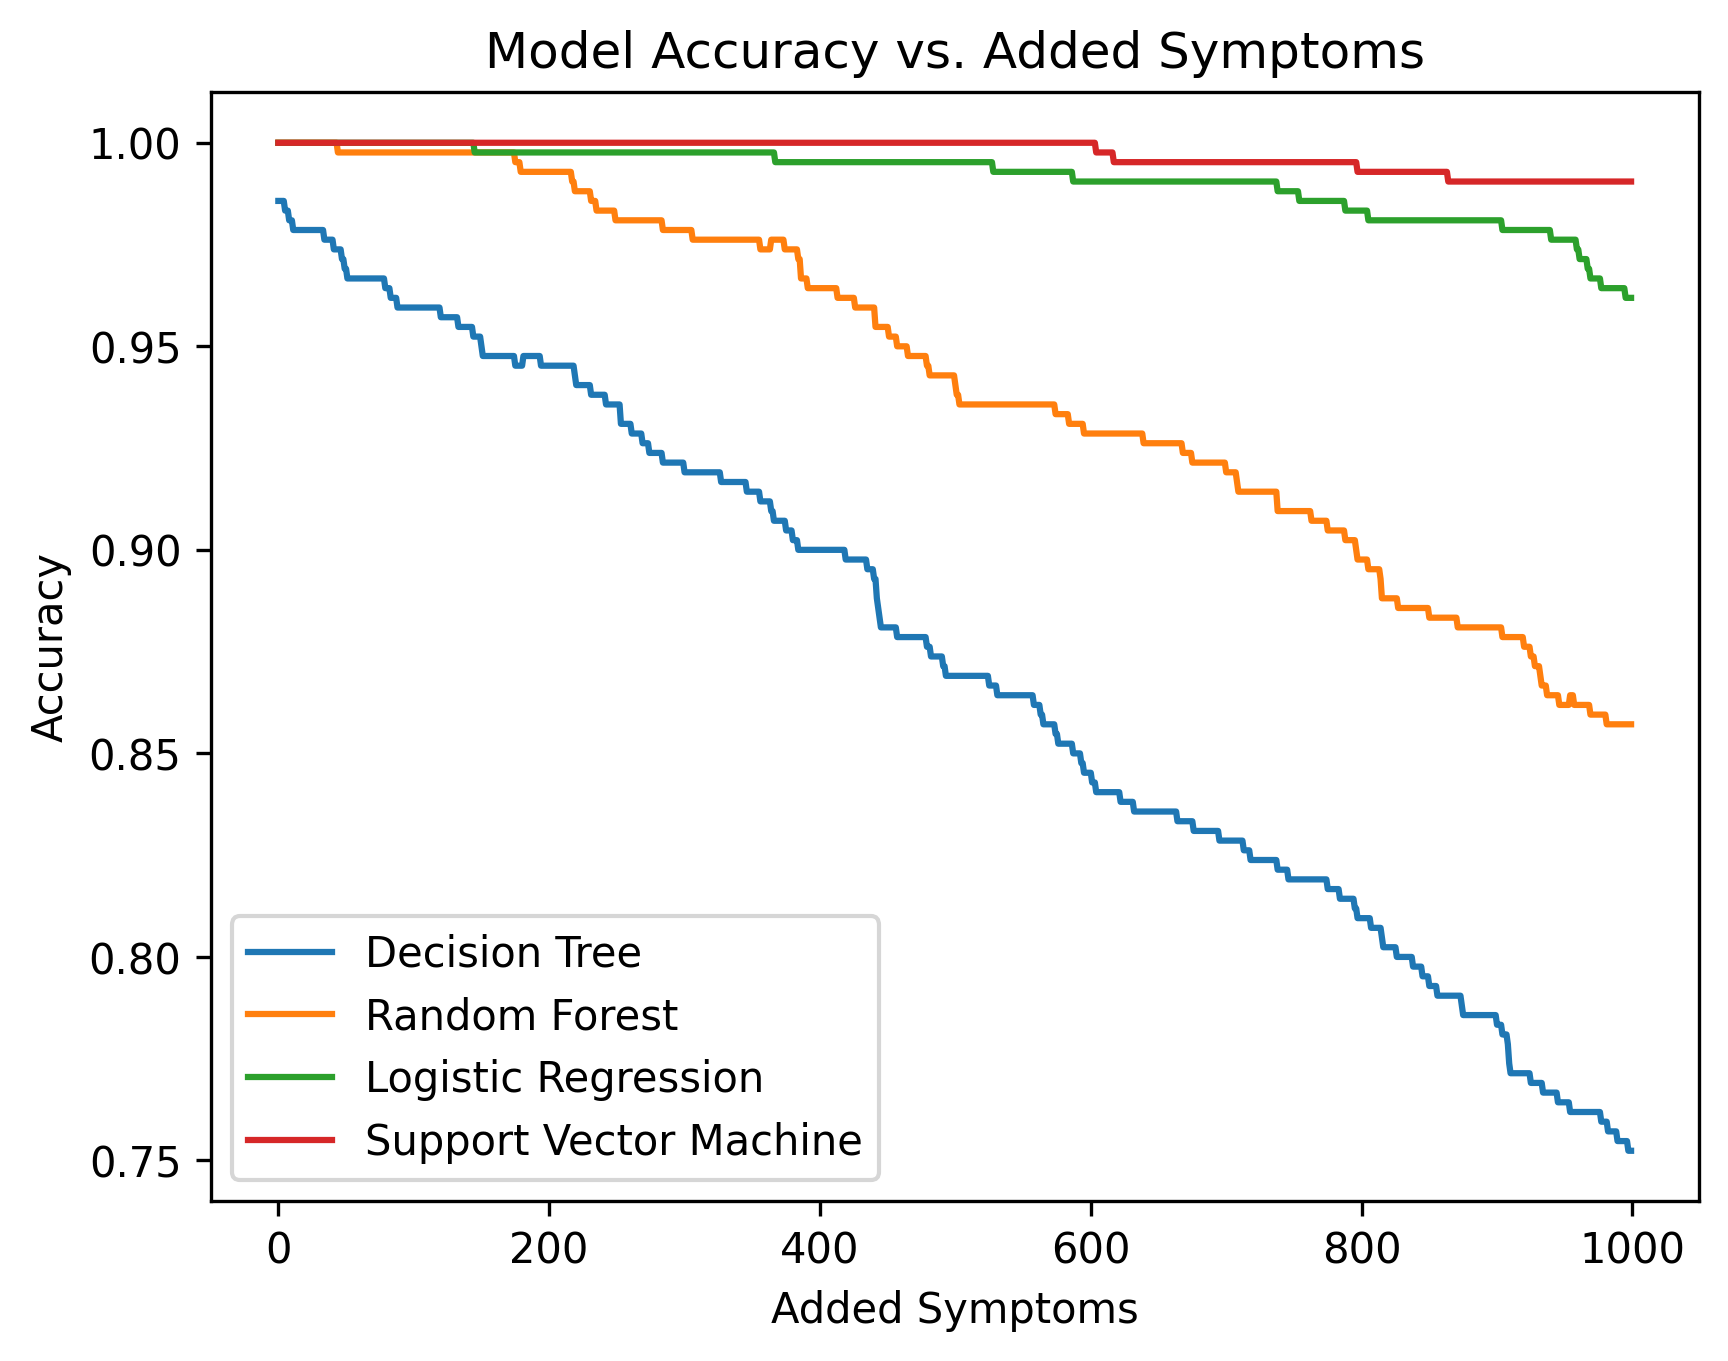

In [129]:
subset = pd.read_csv(r"./Dataset/subset.csv")

X_test, y_test = subset.drop(columns=['Disease']), subset['Disease']

models = []

for model_name in ['decision_tree_model.pkl', 'random_forest_model.pkl', 'logistic_regression_model.pkl', 'support_vector_model.pkl']:
    model_path = f'./Models_Subset/{model_name}'
    model = joblib.load(model_path)
    models.append(model)

#drop a random symptom from a patient
X_sub = subset.drop(columns=['Disease'])  # All columns except Disease
y_sub = subset['Disease']  # Target column

#Split the data
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.7, random_state=42)

dt_accs = []
rf_acces = []
log_acces = []
svm_acces = []

accs = [dt_accs, rf_acces, log_acces, svm_acces]

np.random.seed(42)  # Set the random seed for reproducibility
remove_symptoms = 10  # Number of symptoms to remove
remove = 100

for i in range(1000):
    for remove in range(remove_symptoms):
        #Drop a random symptom from a random patient
        index, columns = np.where(X_test_sub == 0)

        random_patient_index = np.random.choice(index)
        random_symptom_index = np.random.choice(columns)

        X_test_sub.iloc[random_patient_index, random_symptom_index] = 1 # Set the symptom to 0 (not present)

    for j in range(len(models)):
        predictions = models[j].predict(X_test_sub)

        # Evaluate the model
        accuracy = accuracy_score(y_test_sub, predictions)

        accs[j].append(accuracy)

# Plot the accuracies
plt.plot(accs[0], label="Decision Tree")
plt.plot(accs[1], label="Random Forest")
plt.plot(accs[2], label="Logistic Regression")
plt.plot(accs[3], label="Support Vector Machine")
# plt.plot(range(remove_symptoms)*remove,accs[0], label='Decision Tree')
#plt.plot(range(remove_symptoms)*remove,accs[1], label='Random Forest')
#plt.plot(range(remove_symptoms)*remove,accs[2], label='Logistic Regression')
#plt.plot(range(remove_symptoms)*remove,accs[3], label='Support Vector Machine')
plt.xlabel('Added Symptoms')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Added Symptoms')
plt.legend()
plt.savefig('./Plots/Classifier_Subset/accuracy_vs_added_symptoms.pdf')
plt.show()

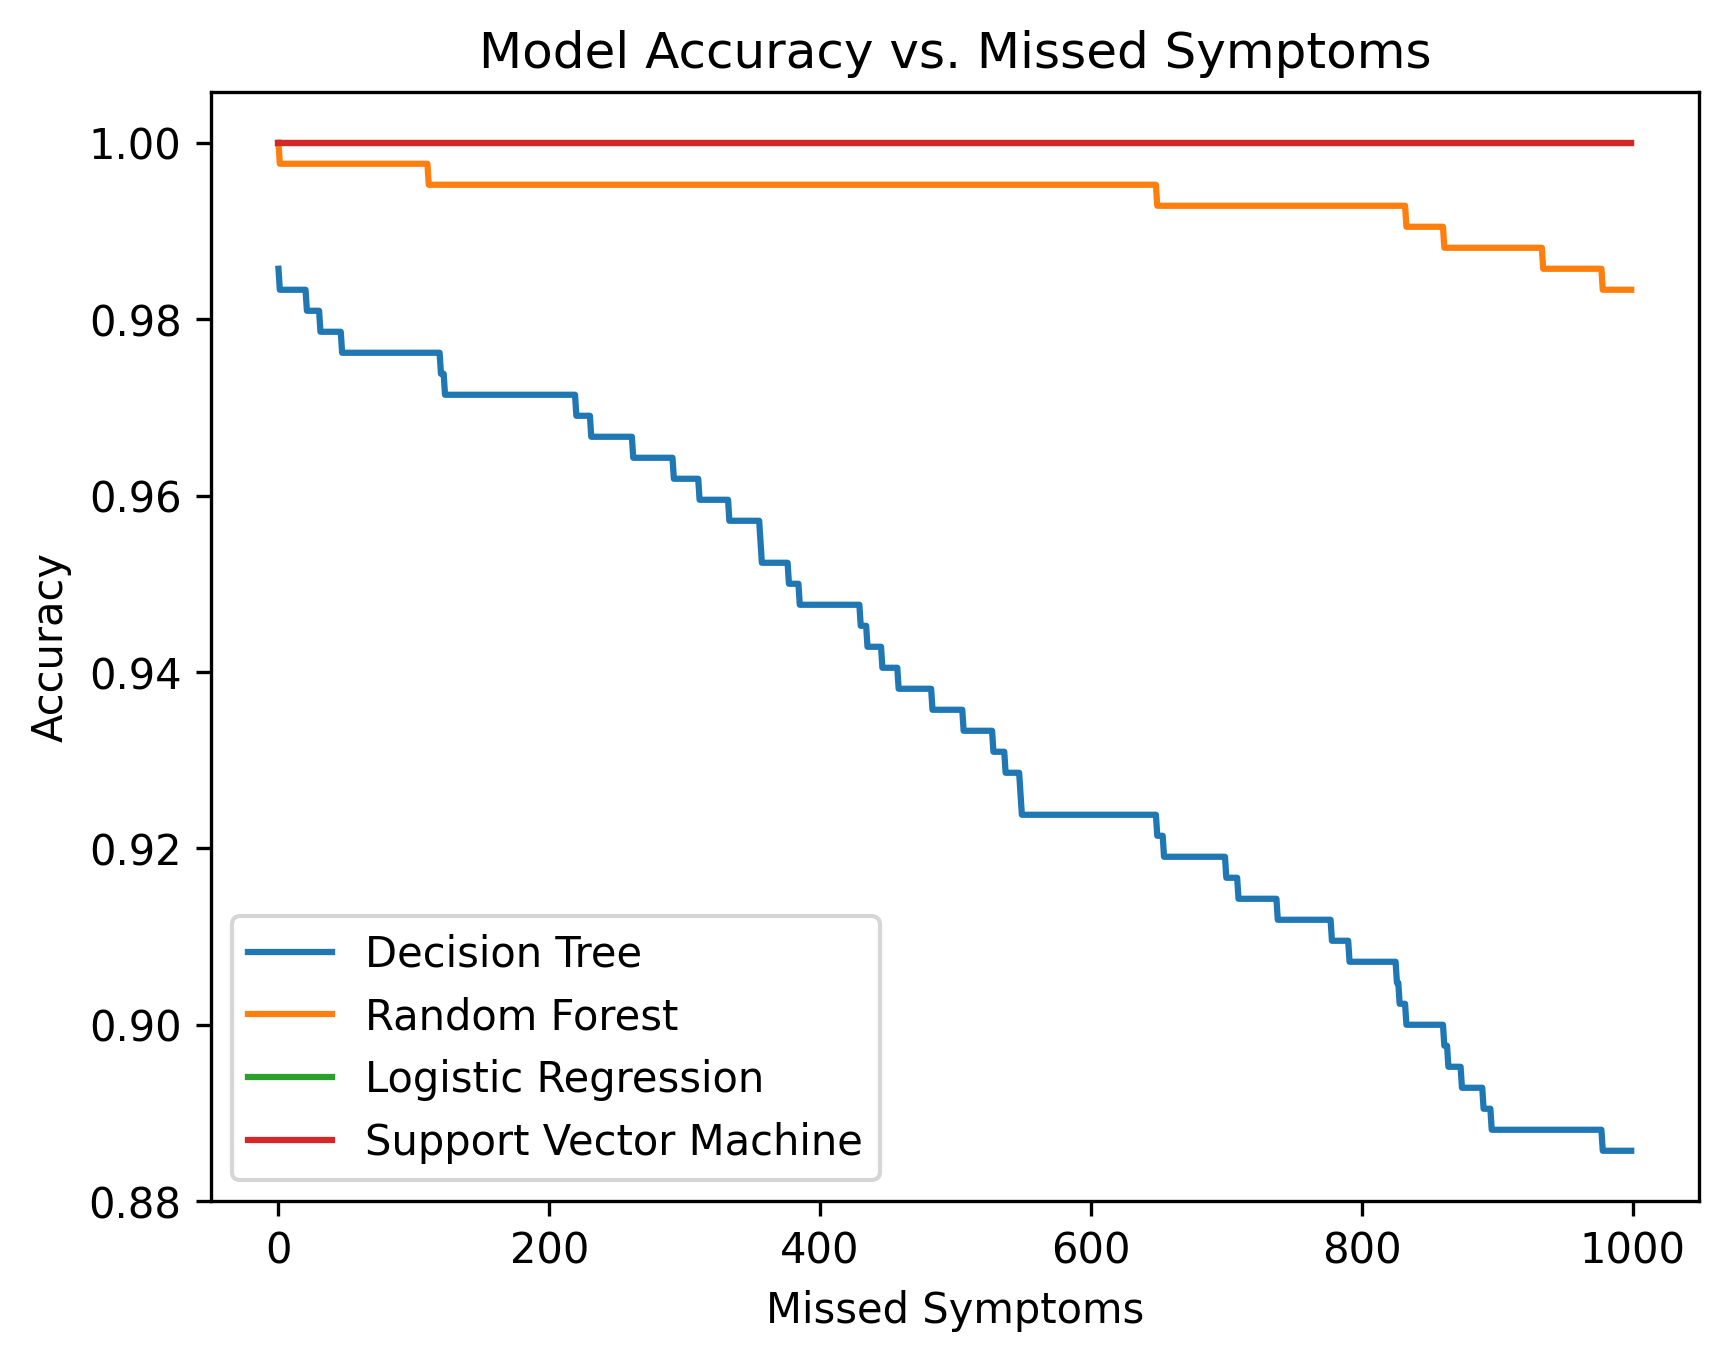

In [130]:
subset = pd.read_csv(r"./Dataset/subset.csv")

X_test, y_test = subset.drop(columns=['Disease']), subset['Disease']

models = []

for model_name in ['decision_tree_model.pkl', 'random_forest_model.pkl', 'logistic_regression_model.pkl', 'support_vector_model.pkl']:
    model_path = f'./Models_Subset/{model_name}'
    model = joblib.load(model_path)
    models.append(model)

#drop a random symptom from a patient
X_sub = subset.drop(columns=['Disease'])  # All columns except Disease
y_sub = subset['Disease']  # Target column

#Split the data
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.7, random_state=42)

dt_accs = []
rf_acces = []
log_acces = []
svm_acces = []

accs = [dt_accs, rf_acces, log_acces, svm_acces]

np.random.seed(42)  # Set the random seed for reproducibility

for i in range(1000):
    #Drop a random symptom from a random patient
    index, columns = np.where(X_test_sub == 1)

    random_patient_index = np.random.choice(index)
    random_symptom_index = np.random.choice(columns)

    X_test_sub.iloc[random_patient_index, random_symptom_index] = 0 # Set the symptom to 0 (not present)

    for j in range(len(models)):
        predictions = models[j].predict(X_test_sub)

        # Evaluate the model
        accuracy = accuracy_score(y_test_sub, predictions)

        accs[j].append(accuracy)

# Plot the accuracies
plt.plot(accs[0], label='Decision Tree')
plt.plot(accs[1], label='Random Forest')
plt.plot(accs[2], label='Logistic Regression')
plt.plot(accs[3], label='Support Vector Machine')
plt.xlabel('Missed Symptoms')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs. Missed Symptoms')
plt.legend()
# Save plot
plt.savefig('./Plots/Classifier_Subset/accuracy_vs_missed_symptoms.pdf')
plt.show()

Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, skipping
Empty columns, s

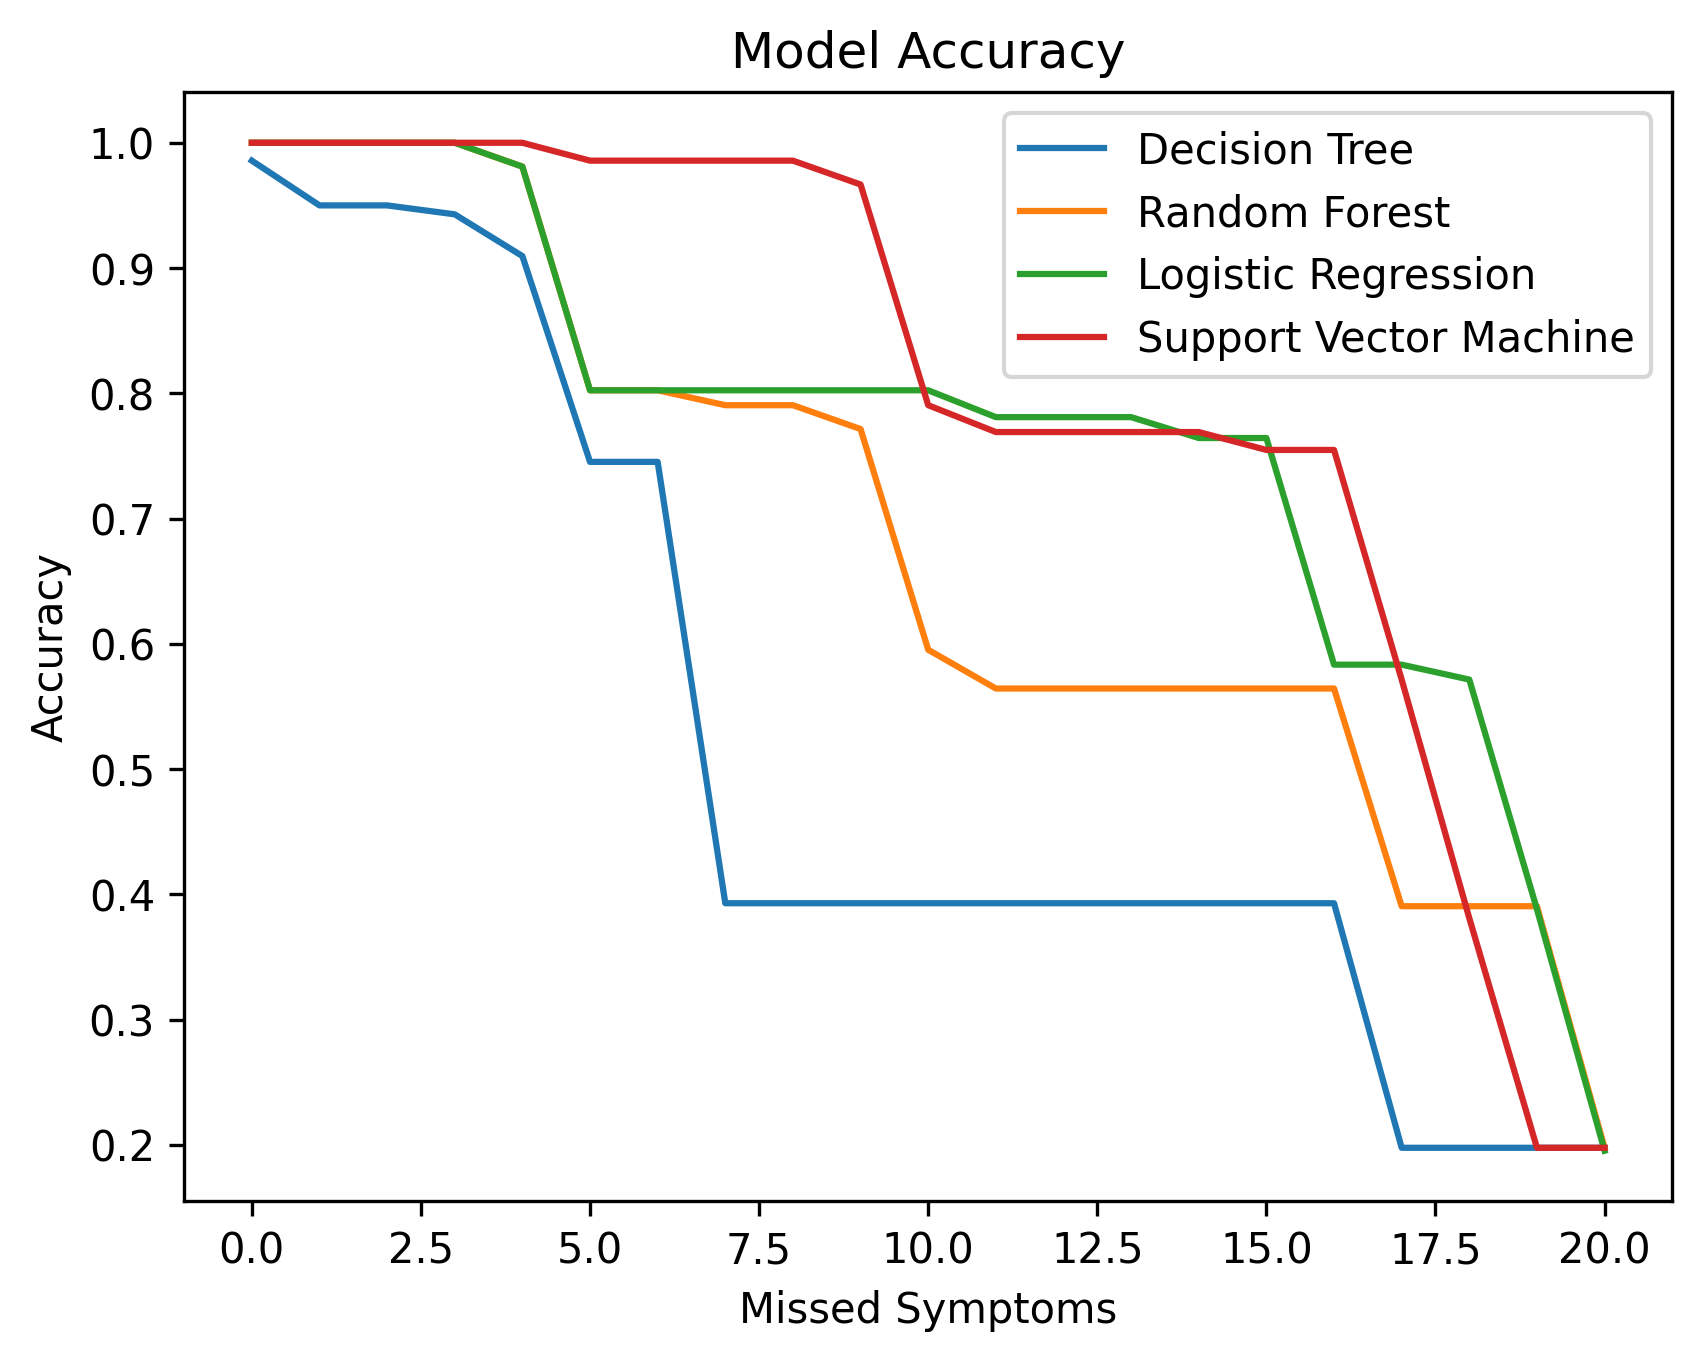

In [134]:
X_sub = subset.drop(columns=['Disease'])  # All columns except Disease
y_sub = subset['Disease']  # Target column

#Split the data
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_sub, y_sub, test_size=0.7, random_state=42)

dt_accs = []
rf_acces = []
log_acces = []
svm_acces = []

accs = [dt_accs, rf_acces, log_acces, svm_acces]

np.random.seed(42)  # Set the random seed for reproducibility

for i in range(len(unique_symptoms)):

    index, columns = np.where(X_test_sub == 1)
    try:
        random_symptom_index = np.random.choice(columns)
    except:
        print("Empty columns, skipping")
        continue

    #print(f"Random Patient Index: {random_patient_index}, Random Symptom Index: {random_symptom_index}")

    X_test_sub.iloc[:, random_symptom_index] = 0 # Set the symptom to 0 (not present)

    for j in range(len(models)):
        predictions = models[j].predict(X_test_sub)

        # Evaluate the model
        accuracy = accuracy_score(y_test_sub, predictions)

        accs[j].append(accuracy)

# Plot the accuracies
plt.plot(accs[0], label='Decision Tree')
plt.plot(accs[1], label='Random Forest')
plt.plot(accs[2], label='Logistic Regression')
plt.plot(accs[3], label='Support Vector Machine')
plt.xlabel('Missed Symptoms')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
# Save plot
plt.savefig('./Plots/Classifier_Subset/model_accuracy_test.pdf')
plt.show()